# Load model from .pb file

This code will load and return the graph.

* `model_file_name`: path to a `.pb` file.
* `node_mapping`: mapping from the name of node in the graph to a Tensorflow node in current session

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.platform import gfile
import pandas as pd
from sklearn.metrics import confusion_matrix

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def load_graph(sess, model_file_name, node_mapping={}):
    with gfile.GFile(model_file_name, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, node_mapping)

This code will load the top-tagging model weights.

Please change the `model_file_name` to the file name of your model.

In [3]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior() 
with tf.Session() as sess:
    # Create a placeholder for the input
    input_node = tf.placeholder(tf.float32, shape = [None, 224, 224, 3], name='Placeholder')
    graph_def = load_graph(sess=sess,
                           model_file_name='constantgraph.pb',
                           node_mapping={'Placeholder': input_node})
# Get the node for output
output_node = tf.get_default_graph().get_tensor_by_name("import/classifier/model_1/classifier_output/Softmax:0")

# Export to Tensorboard

This code will save the graph into a logging directory so that we can inspect it with Tensorboard.

* `log_dir_name`: Path to the directory that is used to store the log. You can use `tensorboard --logdir <log_dir_name>` to inspect the graph.

In [4]:
def write_to_log(log_dir_name):
    LOGDIR='log-top-tagging-resnet50-2'
    train_writer = tf.summary.FileWriter(log_dir_name)
    train_writer.add_graph(sess.graph)

This code will save the top-tagging model to a folder.

Please change the parameter to where you want to store the Tensorboad information.

In [5]:
write_to_log('log-top-tagging-resnet50')

# Run an inference

This code will run an inference on a matrix

In [6]:
import numpy as np
with tf.Session() as sess:
    y = sess.run(output_node, feed_dict={input_node: np.zeros((2, 224, 224, 3))})

In [7]:
print(y)

[[0.00170123 0.9982988 ]
 [0.00170123 0.9982988 ]]


# Evaluate model

Those are helper functions from [util.py](https://github.com/nhanvtran/MachineLearningNotebooks/blob/nvt/bwcustomweights-validate/project-brainwave/utils.py)

In [8]:
def normalize_and_rgb(images): 
    import numpy as np
    #normalize image to 0-255 per image.
    image_sum = 1/np.sum(np.sum(images,axis=1),axis=-1)
    given_axis = 0
    # Create an array which would be used to reshape 1D array, b to have 
    # singleton dimensions except for the given axis where we would put -1 
    # signifying to use the entire length of elements along that axis  
    dim_array = np.ones((1,images.ndim),int).ravel()
    dim_array[given_axis] = -1
    # Reshape b with dim_array and perform elementwise multiplication with 
    # broadcasting along the singleton dimensions for the final output
    image_sum_reshaped = image_sum.reshape(dim_array)
    images = images*image_sum_reshaped*255

    # make it rgb by duplicating 3 channels.
    images = np.stack([images, images, images],axis=-1)
    
    return images

In [9]:
def count_events(train_files):
    import tables
    n_events = 0
    for train_file in train_files:
        f = tables.open_file(train_file, 'r')
        n_events += f.root.label.shape[0]
        f.close()
    return n_events

In [10]:
def chunks(files, chunksize, max_q_size=4, shuffle=True): 
    """Yield successive n-sized chunks from a and b.""" 
    import tables
    import numpy as np
    for train_file in files: 
        f = tables.open_file(train_file, 'r') 
        nrows = f.root.label.nrows
        for istart in range(0,nrows,max_q_size*chunksize):  
            a = np.array(f.root.img_pt[istart:istart+max_q_size*chunksize]) # Images 
            b = np.array(f.root.label[istart:istart+max_q_size*chunksize]) # Labels 
            if shuffle: 
                c = np.c_[a.reshape(len(a), -1), b.reshape(len(b), -1)] # shuffle within queue size
                np.random.shuffle(c)
                test_images = c[:, :a.size//len(a)].reshape(a.shape)
                test_labels = c[:, a.size//len(a):].reshape(b.shape)
            else:
                test_images = a
                test_labels = b
            for jstart in range(0,len(test_labels),chunksize): 
                yield normalize_and_rgb(test_images[jstart:jstart+chunksize].copy()),test_labels[jstart:jstart+chunksize].copy(), len(test_labels[jstart:jstart+chunksize].copy())  
        f.close()

In [11]:
import matplotlib
import matplotlib.pyplot as plt

In [12]:
def plot_loss(x, y):
        plt.figure()
        plt.plot(x,y,label='test_loss')
        plt.xlabel('events')
        plt.ylabel('loss')
        plt.title('Loss per events.')
        plt.show()

In [13]:
def plot_acc(x, y):
        plt.figure()
        plt.plot(x,y,label='test_acc')
        plt.xlabel('events')
        plt.ylabel('acc')
        plt.title('Accuarcy per events')
        plt.show()

In [14]:
def roc_plot(x,y):
        xx = []
        for i in range(0,157):
            xx.append(x[i]/157)
        plt.figure()
        plt.plot(xx,y,label='ResNet-50(area = 0.958)')
        plt.plot(xx,xx,'--',label='Random')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend(loc='lower right')
        plt.title('ROC curve.')
        plt.show()

In [15]:
test_loss_list = []
test_acc_list = []
def test_model(preds, in_images, test_files, chunk_size=64, shuffle=True):
    """Test the model"""
    # import tensorflow as tf 
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior() 
    from keras import backend as K
    from keras.objectives import binary_crossentropy 
    import numpy as np
    from keras.metrics import categorical_accuracy
    from tqdm import tqdm
    
    in_labels = tf.placeholder(tf.float32, shape=(None, 2))
    
    cross_entropy = tf.reduce_mean(binary_crossentropy(in_labels, preds))
    accuracy = tf.reduce_mean(categorical_accuracy(in_labels, preds))
    auc = tf.metrics.auc(tf.cast(in_labels, tf.bool), preds)
   
    n_test_events = count_events(test_files)
    chunk_num = int(n_test_events/chunk_size)+1
    preds_all = []
    label_all = []
    
    sess = tf.Session()
    sess.run(tf.local_variables_initializer())
    
    avg_accuracy = 0
    avg_auc = 0
    avg_test_loss = 0
    is_training = tf.get_default_graph().get_tensor_by_name('import/is_training:0')
    n_current_events = 0
    epoch = 0
    epoch_list = []
    roc_curve = []
    for img_chunk, label_chunk, real_chunk_size in chunks(test_files, chunk_size, shuffle=shuffle):
        test_loss, accuracy_result, auc_result, preds_result = sess.run([cross_entropy, accuracy, auc, preds],
                        feed_dict={in_images: img_chunk,
                                   in_labels: label_chunk,
                                   K.learning_phase(): 0,
                                   is_training: False})
        avg_test_loss += test_loss * real_chunk_size / n_test_events
        avg_accuracy += accuracy_result * real_chunk_size / n_test_events
        avg_auc += auc_result[0]  * real_chunk_size / n_test_events 
        preds_all.extend(preds_result)
        label_all.extend(label_chunk)
        n_current_events += real_chunk_size
        
        test_loss_list.append( avg_test_loss*n_test_events/n_current_events)
        test_acc_list.append( avg_accuracy*n_test_events/n_current_events )
        roc_curve.append( avg_auc*n_test_events/n_current_events )
        if(epoch < 157 ):
            epoch += 1
            epoch_list.append(epoch)
        
        print("test_loss = ", "{:.3f}".format(avg_test_loss*n_test_events/n_current_events), end="")
        print("Test Accuracy:", "{:.3f}".format(avg_accuracy*n_test_events/n_current_events), ", Area under ROC curve:", "{:.3f}".format(avg_auc*n_test_events/n_current_events))
        print(epoch)
    
    return epoch_list, test_loss_list, test_acc_list, roc_curve, avg_test_loss, avg_accuracy, avg_auc, np.asarray(preds_all).reshape(n_test_events,2), np.asarray(label_all).reshape(n_test_events,2)

* `Input Size`: 64 by 64 image upsampled to 224 * 224 * 3 (224 by 224 channel duplicated 3 times for RGB)
* `Operations`: resize, padding, conv2d, batchnorm, relu, maxpool
* Adam with 10^-3 learning rate , minibatch size of 64, over 10 epochs
* quantized version of Resnet50 needs to be trained with smaller learning rate of 10^-4 `
* `Loss Function`: Binary Crossentropy

This will test the model on a test file.

Please change the parameter so that it uses the correct file.

In [17]:
epoch_list, test_loss_list, test_acc_list, roc_curve, avg_test_loss, avg_accuracy, avg_auc, preds_all, label_all = test_model(output_node, input_node, ['test_file_0.h5'])

Instructions for updating:
The value of AUC returned by this may race with the update so this is deprected. Please use tf.keras.metrics.AUC instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Using TensorFlow backend.


test_loss =  0.247Test Accuracy: 0.922 , Area under ROC curve: 0.000
1
test_loss =  0.257Test Accuracy: 0.914 , Area under ROC curve: 0.490
2
test_loss =  0.249Test Accuracy: 0.917 , Area under ROC curve: 0.651
3
test_loss =  0.290Test Accuracy: 0.906 , Area under ROC curve: 0.732
4
test_loss =  0.260Test Accuracy: 0.912 , Area under ROC curve: 0.779
5
test_loss =  0.260Test Accuracy: 0.911 , Area under ROC curve: 0.811
6
test_loss =  0.268Test Accuracy: 0.904 , Area under ROC curve: 0.834
7
test_loss =  0.268Test Accuracy: 0.908 , Area under ROC curve: 0.852
8
test_loss =  0.260Test Accuracy: 0.911 , Area under ROC curve: 0.865
9
test_loss =  0.271Test Accuracy: 0.906 , Area under ROC curve: 0.876
10
test_loss =  0.261Test Accuracy: 0.905 , Area under ROC curve: 0.885
11
test_loss =  0.275Test Accuracy: 0.902 , Area under ROC curve: 0.892
12
test_loss =  0.285Test Accuracy: 0.898 , Area under ROC curve: 0.898
13
test_loss =  0.286Test Accuracy: 0.898 , Area under ROC curve: 0.903
14
t

test_loss =  0.317Test Accuracy: 0.894 , Area under ROC curve: 0.956
115
test_loss =  0.317Test Accuracy: 0.894 , Area under ROC curve: 0.956
116
test_loss =  0.316Test Accuracy: 0.894 , Area under ROC curve: 0.956
117
test_loss =  0.315Test Accuracy: 0.894 , Area under ROC curve: 0.956
118
test_loss =  0.314Test Accuracy: 0.894 , Area under ROC curve: 0.956
119
test_loss =  0.313Test Accuracy: 0.895 , Area under ROC curve: 0.956
120
test_loss =  0.313Test Accuracy: 0.895 , Area under ROC curve: 0.956
121
test_loss =  0.312Test Accuracy: 0.895 , Area under ROC curve: 0.956
122
test_loss =  0.312Test Accuracy: 0.895 , Area under ROC curve: 0.957
123
test_loss =  0.311Test Accuracy: 0.895 , Area under ROC curve: 0.957
124
test_loss =  0.310Test Accuracy: 0.895 , Area under ROC curve: 0.957
125
test_loss =  0.311Test Accuracy: 0.894 , Area under ROC curve: 0.957
126
test_loss =  0.310Test Accuracy: 0.895 , Area under ROC curve: 0.957
127
test_loss =  0.311Test Accuracy: 0.895 , Area under

In [19]:
m1_cm = pd.DataFrame(confusion_matrix(np.argmax(label_all, axis=1),np.argmax(preds_all, axis=1)))
m1_cm

,0,1
0,4850,70
1,992,4088


In [26]:
TP = m1_cm[0][0]
FP = m1_cm[0][1]
FN = m1_cm[1][0]
TN = m1_cm[1][1]
TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
pre = TP / (TP+FP)
rec = TP / (TP+FN)
f1 = 2 * ((pre*rec)/(pre+rec))
print(f' TPR = {TPR} \n FPR = {FPR} \n precision = {pre} \n recall = {rec} \n F1 score = {f1}')

 TPR = 0.9857723577235772 
 FPR = 0.1952755905511811 
 precision = 0.8301951386511469 
 recall = 0.9857723577235772 
 F1 score = 0.901319457349935


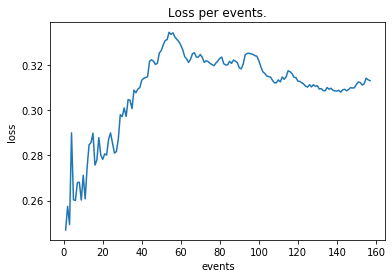

In [20]:
plot_loss(epoch_list, test_loss_list)

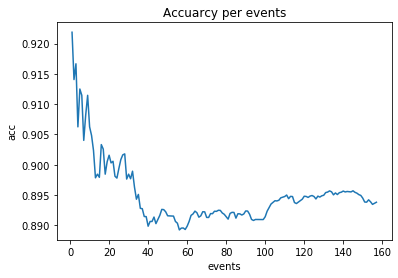

In [21]:
plot_acc(epoch_list, test_acc_list)

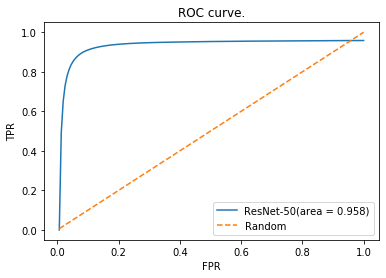

In [22]:
roc_plot(epoch_list, roc_curve)

In [ ]:
# Once results have been compiled, use this function to plot them.
# It expects all the files to be there at runtime, so if they haven't yet been generated,
# comment out the relevant lines.
def plot_results(epoch_list, test_loss_list, test_acc_list, roc_curve, avg_test, avg_acc, avg_auc, test_preds_t, test_labels_t,plot_label='ROC.pdf'):
    import os
    import numpy as np
    from sklearn import metrics

    # Load the labels and results into memory.
    # test_labels_t  = np.load(results_dir + "/t_labels.npy")
    # test_preds_t   = np.load(results_dir + "/t_preds.npy")
    # accuracy_q     = np.load(results_dir + "/q_accuracy.npy")
    # test_labels_q  = np.load(results_dir + "/q_labels.npy")
    # test_preds_q   = np.load(results_dir + "/q_preds.npy")
    # test_labels_ft = np.load(results_dir + "/ft_labels.npy")
    # test_preds_ft  = np.load(results_dir + "/ft_preds.npy")
    # test_labels_b = np.load(results_dir + "/b_labels.npy")
    # test_preds_b  = np.load(results_dir + "/b_preds.npy")
    # test_labels_b_ft = np.load(results_dir + "/b_labels.npy")
    # test_preds_b_ft  = np.load(results_dir + "/b_newpreds.npy")

    new_test_preds_t = np.zeros(test_preds_t.shape)
    new_test_preds_t[:,0] = test_preds_t[:,0]/np.sum(test_preds_t,axis=1)
    new_test_preds_t[:,1] = test_preds_t[:,1]/np.sum(test_preds_t,axis=1)
    test_preds_t = new_test_preds_t

    # new_test_preds_q = np.zeros(test_preds_q.shape)
    # new_test_preds_q[:,0] = test_preds_q[:,0]/np.sum(test_preds_q,axis=1)
    # new_test_preds_q[:,1] = test_preds_q[:,1]/np.sum(test_preds_q,axis=1)
    # test_preds_q = new_test_preds_q

    # new_test_preds_ft = np.zeros(test_preds_ft.shape)
    # new_test_preds_ft[:,0] = test_preds_ft[:,0]/np.sum(test_preds_ft,axis=1)
    # new_test_preds_ft[:,1] = test_preds_ft[:,1]/np.sum(test_preds_ft,axis=1)
    # test_preds_ft = new_test_preds_ft

    # new_test_preds_b = np.zeros(test_preds_b.shape)
    # new_test_preds_b[:,0] = test_preds_b[:,0]/np.sum(test_preds_b,axis=1)
    # new_test_preds_b[:,1] = test_preds_b[:,1]/np.sum(test_preds_b,axis=1)
    # test_preds_b = new_test_preds_b
    
    # new_test_preds_b_ft = np.zeros(test_preds_b_ft.shape)
    # new_test_preds_b_ft[:,0] = test_preds_b_ft[:,0]/np.sum(test_preds_b_ft,axis=1)
    # new_test_preds_b_ft[:,1] = test_preds_b_ft[:,1]/np.sum(test_preds_b_ft,axis=1)
    # test_preds_b_ft = new_test_preds_b_ft
    
    accuracy_t = metrics.accuracy_score(test_labels_t[:,0], test_preds_t[:,0]>0.5)
    # accuracy_q = metrics.accuracy_score(test_labels_q[:,0], test_preds_q[:,0]>0.5)
    # accuracy_ft = metrics.accuracy_score(test_labels_ft[:,0], test_preds_ft[:,0]>0.5)
    # accuracy_b = metrics.accuracy_score(test_labels_b[:,0], test_preds_b[:,0]>0.5)
    # accuracy_b_ft = metrics.accuracy_score(test_labels_b_ft[:,0], test_preds_b_ft[:,0]>0.5)

    # Determine the ROC curve for each of the tests. 
    # [:,0] will convert the labels from one-hot to binary.
    fpr_test_t, tpr_test_t, thresholds      = metrics.roc_curve(test_labels_t[:,0],  test_preds_t[:,0])
    # fpr_test_q, tpr_test_q, thresholds_q    = metrics.roc_curve(test_labels_q[:,0],  test_preds_q[:,0])
    # fpr_test_ft, tpr_test_ft, thresholds_ft    = metrics.roc_curve(test_labels_ft[:,0],  test_preds_ft[:,0])
    # fpr_test_b, tpr_test_b, thresholds_b    = metrics.roc_curve(test_labels_b[:,0],  test_preds_b[:,0])
    # fpr_test_b_ft, tpr_test_b_ft, thresholds_b_ft    = metrics.roc_curve(test_labels_b_ft[:,0],  test_preds_b_ft[:,0])
    
    # Use the data we just generated to determine the area under the ROC curve.
    # Use the data we just generated to determine the area under the ROC curve.
    auc_test    = metrics.auc(fpr_test_t, tpr_test_t)
    # auc_test_q  = metrics.auc(fpr_test_q, tpr_test_q)
    # auc_test_ft  = metrics.auc(fpr_test_ft, tpr_test_ft)
    # auc_test_b  = metrics.auc(fpr_test_b, tpr_test_b)
    # auc_test_b_ft  = metrics.auc(fpr_test_b_ft, tpr_test_b_ft)

# Load model from .h5 file

Change `file_name` to the path of model.

In [ ]:
import keras
file_name = 'class_model_best.h5'
new_model = keras.models.load_model(file_name)
new_model.summary()

In [ ]:
plot = plot_results(test_model(output_node, input_node, ['test_file_0.h5']))
plot.show()